In [1]:
import numpy as np
from mpnet.sst_envs.utils import load_data, get_obs_3d
import pickle
import time
import click
from tqdm.auto import tqdm
from pathlib import Path
import importlib
from matplotlib import pyplot as plt

import sys
sys.path.append('/media/arclabdl1/HD1/Linjun/mpc-mpnet-py/deps/sparse_rrt-1')

from sparse_rrt import _deep_smp_module
# from params.cpp_dst_s32_e4 import get_params

def experiment_vis(env_id, traj_id, verbose=False, system='quadrotor_obs', params=None, number_of_iterations=1):
    print("env {}, traj {}".format(env_id, traj_id))
    obs_list = get_obs_3d(system, env_id)[env_id].reshape(-1, 3)
    data = load_data(system, env_id, traj_id)
    ref_path = data['path']
    start_goal = data['start_goal']
    # print(start_goal)
    env_vox = np.load('mpnet/sst_envs/data/{}_env_vox.npy'.format(system))
    obc = env_vox[env_id]
    print(obc.shape)
    # print(obs_list)
    params = params
    #number_of_iterations = params['number_of_iterations'] #3000000# 
    min_time_steps = params['min_time_steps'] if 'min_time_steps' in params else 80
    max_time_steps = params['max_time_steps'] if 'min_time_steps' in params else 400
    integration_step = params['dt']
    

    planner = _deep_smp_module.DSSTMPCWrapper(
        system_type=system,
        start_state=np.array(ref_path[0]),
    #             goal_state=np.array(ref_path[-1]),
        goal_state=np.array(data['start_goal'][-1]),
        goal_radius=params['goal_radius'],
        random_seed=0,
        sst_delta_near=params['sst_delta_near'],
        sst_delta_drain=params['sst_delta_drain'],
        obs_list=obs_list,
        width=params['width'],
        verbose=params['verbose'],
        mpnet_weight_path=params['mpnet_weight_path'], 
        cost_predictor_weight_path=params['cost_predictor_weight_path'],
        cost_to_go_predictor_weight_path=params['cost_to_go_predictor_weight_path'],
        num_sample=params['cost_samples'],
        np=params['n_problem'], ns=params['n_sample'], nt=params['n_t'], ne=params['n_elite'], max_it=params['max_it'],
        converge_r=params['converge_r'], mu_u=params['mu_u'], std_u=params['sigma_u'], mu_t=params['mu_t'], 
        std_t=params['sigma_t'], t_max=params['t_max'], step_size=params['step_size'], integration_step=params['dt'], 
        device_id=params['device_id'], refine_lr=params['refine_lr'],
        weights_array=params['weights_array'],
        obs_voxel_array=obc.reshape(-1)
    )
    return data, planner

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def draw_line_3d(ax, p, p_index, color='b', alpha=1):
    for p_i in p_index:
        ax.plot3D(p[p_i, 0], p[p_i, 1], p[p_i, 2], c=color, alpha=alpha)

def centered_box_to_points_3d(center, size):
    half_size = [s/2 for s in size]
    direction, p = [1, -1], []
    for x_d in direction:
        for y_d in direction:
            for z_d in direction:
                p.append([center[di] + [x_d, y_d, z_d][di] * half_size[0] for di in range(3)])
    return p

def rot_frame_3d(state, frame_size=0.25):
    b, c, d, a = state[3:7]
    rot_mat = np.array([[2 * a**2 - 1 + 2 * b**2, 2 * b * c + 2 * a * d, 2 * b * d - 2 * a * c],
                        [2 * b * c - 2 * a * d, 2 * a**2 - 1 + 2 * c**2, 2 * c * d + 2 * a * b],
                        [2 * b * d + 2 * a * c, 2 * c * d - 2 * a * b, 2 * a**2 - 1 + 2 * d**2]])
    quadrotor_frame = np.array([[frame_size, 0, 0],
                                 [0, frame_size, 0],
                                 [-frame_size, 0, 0],
                                 [0, -frame_size, 0]]).T
    quadrotor_frame = rot_mat @ quadrotor_frame + state[:3].reshape(-1, 1)
    return quadrotor_frame

def q_to_points_3d(state):
    quadrotor_frame = rot_frame_3d(state)   
    max_min, direction = [np.max(quadrotor_frame, axis=1), np.min(quadrotor_frame, axis=1)], [1, 0]
    p = []
    for x_d in direction:
        for y_d in direction:
            for z_d in direction:
                p.append([max_min[x_d][0], max_min[y_d][1], max_min[z_d][2]])
    return np.array(p)

def draw_box_3d(ax, p, color='b', alpha=1, surface_color='blue', linewidths=1, edgecolors='k'):
    index_lists = [[[0, 4], [4, 6], [6, 2], [2, 0], [0, 1], [1, 5], [5, 7], [7, 3], [3, 1], [1, 5]],
                  [[4, 5]],
                  [[6, 7]],
                  [[2, 3]]]
    for p_i in index_lists:
        draw_line_3d(ax, np.array(p), p_i, color=color, alpha=alpha)
    edges = [[p[e_i] for e_i in f_i] for f_i in [[0, 1, 5, 4],
                                                 [4, 5, 7, 6],
                                                 [6, 7, 3, 2],
                                                 [2, 0, 1, 3],
                                                 [2, 0, 4, 6],
                                                 [3, 1, 5, 7]]]
    faces = Poly3DCollection(edges, linewidths=linewidths, edgecolors=edgecolors)
    faces.set_facecolor(surface_color)
    faces.set_alpha(0.1)
    ax.add_collection3d(faces)


def visualize_quadrotor_path(path, start_state, goal_state, obs_list, fig=None, ax=None, draw_bbox=True, width=1, savefig=False):
    if ax is None or fig is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
    
    counter = 0

    for obs in obs_list:
        draw_box_3d(ax, centered_box_to_points_3d(center=obs, size=[width]*3))
    
    ax.scatter(start_state[0], start_state[1], start_state[2], c='red')
    ax.scatter(goal_state[0], goal_state[1], goal_state[2], c='orange')
    draw_box_3d(ax, q_to_points_3d(start_state), alpha=0.3, surface_color="orange", linewidths=0.)
    draw_box_3d(ax, q_to_points_3d(goal_state), alpha=0.3, surface_color="orange", linewidths=0.)
    
    if path is not None:
        ax.scatter(path[:, 0], path[:, 1], path[:, 2], c='blue')
        ax.plot(path[:, 0], path[:, 1], path[:, 2], c='blue')
        
        for waypoint in path:
            f = rot_frame_3d(waypoint)
            ax.scatter(f[0], f[1], f[2], color='red', s=10)
            ax.plot(f[0,[0, 2]], f[1, [0, 2]], f[2, [0, 2]], c='b')
            ax.plot(f[0,[1, 3]], f[1, [1, 3]], f[2, [1, 3]], c='b')

            if draw_bbox:
                draw_box_3d(ax, q_to_points_3d(waypoint), alpha=0.3, surface_color="orange", linewidths=0.)
    
            ax.set_xlim3d(-5, 5)
            ax.set_ylim3d(-5, 5)
            ax.set_zlim3d(-5, 5)
            if savefig:
                fig.savefig("figs/{}.png".format(counter))
            counter += 1
    
    return fig, ax

In [3]:
env_id = 0
traj_id = 900
system = 'quadrotor_obs'
config = 'default'
params = {
        'n_problem': 1,
        'n_sample': 32,
        'n_elite': 4,
        'n_t': 1,
        'max_it': 5,
        'converge_r': 1e-10,

        'dt': 2e-3,

        'mu_u': [-10, 0, 0, 0],
        'sigma_u': [15, 1, 1, 1],

        'mu_t': 0.5,
        'sigma_t': 1,
        't_max': 2,

        'verbose':  False,#True,#
        'step_size': 1,

        "goal_radius": 2,

        "sst_delta_near": .1,
        "sst_delta_drain": 0.,
        "goal_bias": 0.0,

        "width": 1,
        "hybrid": False,
        "hybrid_p": 0.0,

        "cost_samples": 5,
        "mpnet_weight_path": "mpnet/exported/output/quadrotor_obs/mpnet.pt",
        "cost_predictor_weight_path": "",
        "cost_to_go_predictor_weight_path": "mpnet/exported/output/quadrotor_obs/cost_to_go.pt",

        "refine": False,
        "using_one_step_cost": False,
        "refine_lr": 0.,
        "refine_threshold": 0.,
        "device_id": "cuda:2",

        "cost_reselection": False,
        "number_of_iterations": 10000,
        "weights_array": np.ones(13),
        "shm_max_steps": 100,

        'max_planning_time': 500,
    }


def visualize_pair(start, sample, actual, ax=plt):
    # for state
    ax.scatter(start[0], start[1], start[2], c='blue')
    ax.scatter(sample[0], sample[1], sample[2], c='skyblue')
    ax.plot([start[0], sample[0]], [start[1], sample[1]], [start[2], sample[2]], color='skyblue')
    
    ax.scatter(actual[0], actual[1], actual[2], c='green')
    ax.plot([start[0], actual[0]], [start[1], actual[1]], [start[2], actual[2]], color='lime')

env 0, traj 900
(32, 32, 32)


<IPython.core.display.Javascript object>


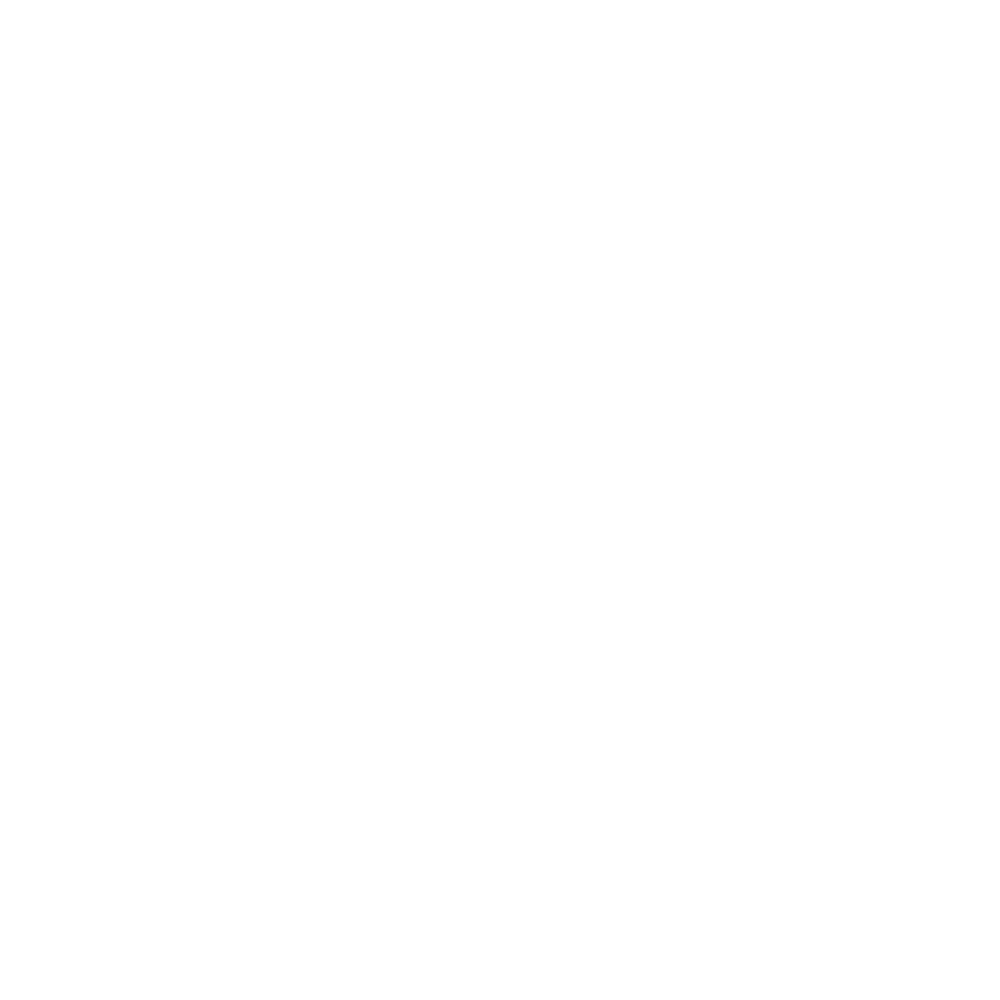

[-2.88453023  4.14163766  4.10582389 -0.00503754 -0.03718011 -0.03597447
  0.99864837 -0.07656603  0.01215593  0.49601626 -0.02302123 -0.16991065
 -0.16440095]
[-2.99317046  3.66354366  4.2616327   0.222589    0.0229722  -0.28968586
  0.93059635 -0.38241977 -1.          0.07854848  0.04789475  0.26543163
 -0.50510553]
[-3.01882297  3.03860878  4.54258311  0.1707839   0.30048765 -0.29866634
  0.88957276  0.88476985 -1.          0.48651335 -0.31149962  0.54602415
  0.0832923 ]
[-2.56261747  2.49460878  4.4730974   0.06238396  0.17338085 -0.16214965
  0.96941012  1.         -1.          0.22607776 -0.0958385  -0.37032712
  0.49659617]
[-1.98661747  1.91860878  4.71756919  0.15654772  0.13386214  0.06698792
  0.97626199  1.         -1.          0.37136832  0.34785611  0.22393856
  0.41105453]
[-1.35478283  1.38277332  4.39202203 -0.04818081  0.10737156  0.34893146
  0.92972995  0.84600206 -0.31466609 -0.22467739 -0.19270484  0.4217557
  0.26472406]
[-0.97514279  1.37965572  4.53945952 -0.0

In [4]:
%matplotlib notebook

data, planner = experiment_vis(env_id, 
                    traj_id, 
                    verbose=False, 
                    system='quadrotor_obs', 
                    params=params, 
                    number_of_iterations=params['number_of_iterations'])


ref_path = data['path']

# fig, ax =  visualize_quadrotor_path(ref_path, 
#                                     data['start_goal'][0],
#                                     data['start_goal'][-1], 
#                                     obs_list=get_obs_3d('quadrotor_obs',"obs")[env_id])
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')


state = np.repeat(np.array([ref_path[0].copy()]), params['n_problem'],  axis=0)

actual_path = []

full_time = 0
import time
for i in range(len(ref_path)-1):
    tic = time.perf_counter()
    state = np.repeat(np.array([ref_path[i].copy()]), params['n_problem'],  axis=0)
    sample =  np.repeat(np.array([ref_path[i+1].copy()]), params['n_problem'],  axis=0)
    actual_state = planner.steer_batch(state, sample, params['n_problem'])[0]
    print(actual_state)
    toc = time.perf_counter()
    time_cost = toc - tic
    full_time += time_cost
    actual_path.append(actual_state)
    state = np.repeat(np.array([actual_state.copy()]), params['n_problem'],  axis=0)#actual_state.copy()
print("total: {}".format(full_time))

actual_path = np.array(actual_path)

# ax.plot(ref_path[:, 0], ref_path[:, 1], ref_path[:, 2])
# ax.scatter(ref_path[:, 0], ref_path[:, 1], ref_path[:, 2])

ax.plot(actual_path[:, 0], actual_path[:, 1], actual_path[:, 2])
ax.scatter(actual_path[:, 0], actual_path[:, 1], actual_path[:, 2])

env 0, traj 900
(32, 32, 32)


<IPython.core.display.Javascript object>


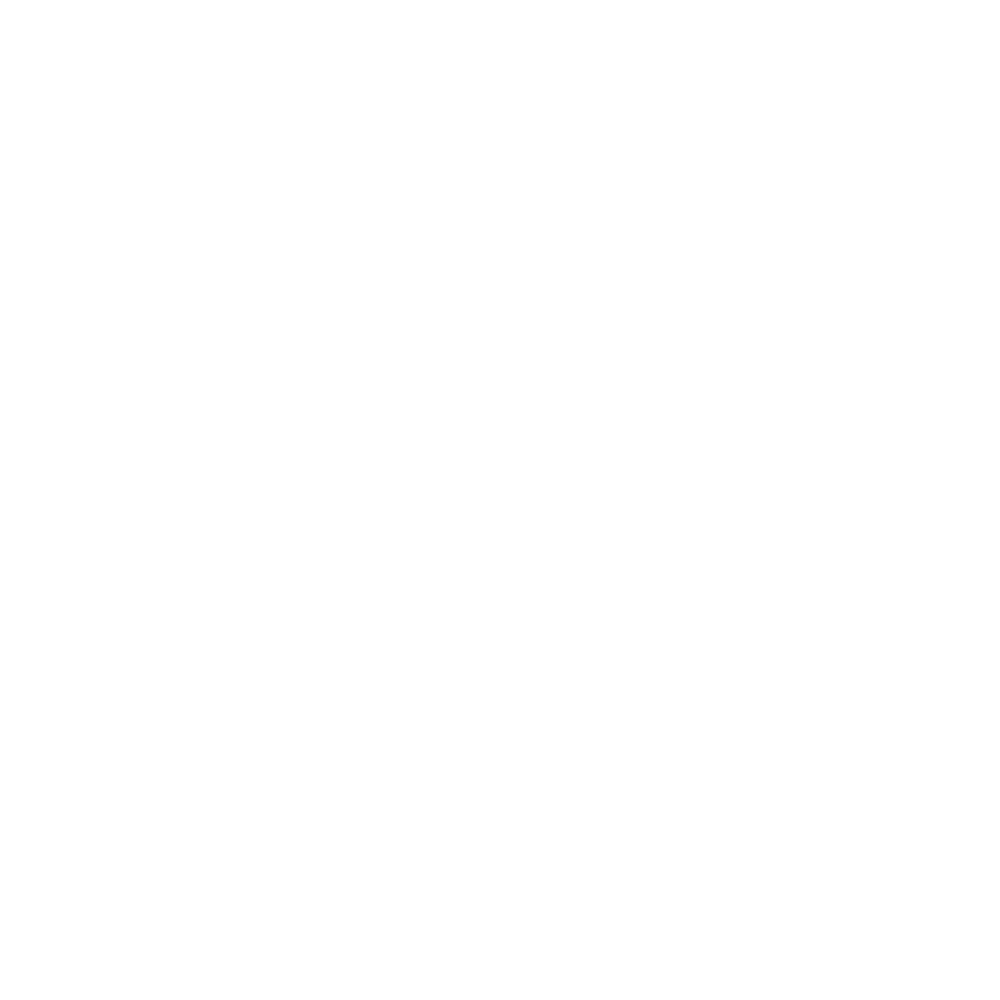

(-5.0, 5.0)

In [5]:
%matplotlib notebook

data, planner = experiment_vis(env_id, 
                    traj_id, 
                    verbose=False, 
                    system='quadrotor_obs', 
                    params=params, 
                    number_of_iterations=params['number_of_iterations'])


ref_path = data['path']

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')


# state = np.repeat(np.array([ref_path[0].copy()]), params['n_problem'],  axis=0)
actual_state = ref_path[0].copy()

actual_path = []
samples = []

full_time = 0



import time
for i in range(len(ref_path)):
    start  = ref_path[i].astype(float).copy()
#     print(start)
    for j in range(1):
        sample = planner.neural_sample(start)
    #     print(sample)
        actual_state = planner.steer(start, sample)
    #     print(actual_state)
        actual_path.append(actual_state.copy())
        ax.plot([start[0], sample[0]], [start[1], sample[1]], [start[2], sample[2]], c='skyblue')
        ax.plot([start[0], actual_state[0]], [start[1], actual_state[1]], [start[2], actual_state[2]], c='green')

actual_path = np.array(actual_path)


ax.plot(ref_path[:, 0], ref_path[:, 1], ref_path[:, 2], c='orange')
ax.scatter(ref_path[:, 0], ref_path[:, 1], ref_path[:, 2], c='orange')
ax.scatter(ref_path[0, 0], ref_path[0, 1], ref_path[0, 2], c='blue')

# ax.plot(actual_path[:, 0], actual_path[:, 1], actual_path[:, 2])
# ax.scatter(actual_path[:, 0], actual_path[:, 1], actual_path[:, 2])
ax.set_xlim3d(-5, 5)
ax.set_ylim3d(-5, 5)
ax.set_zlim3d(-5, 5)

env 5, traj 950
(32, 32, 32)


<IPython.core.display.Javascript object>


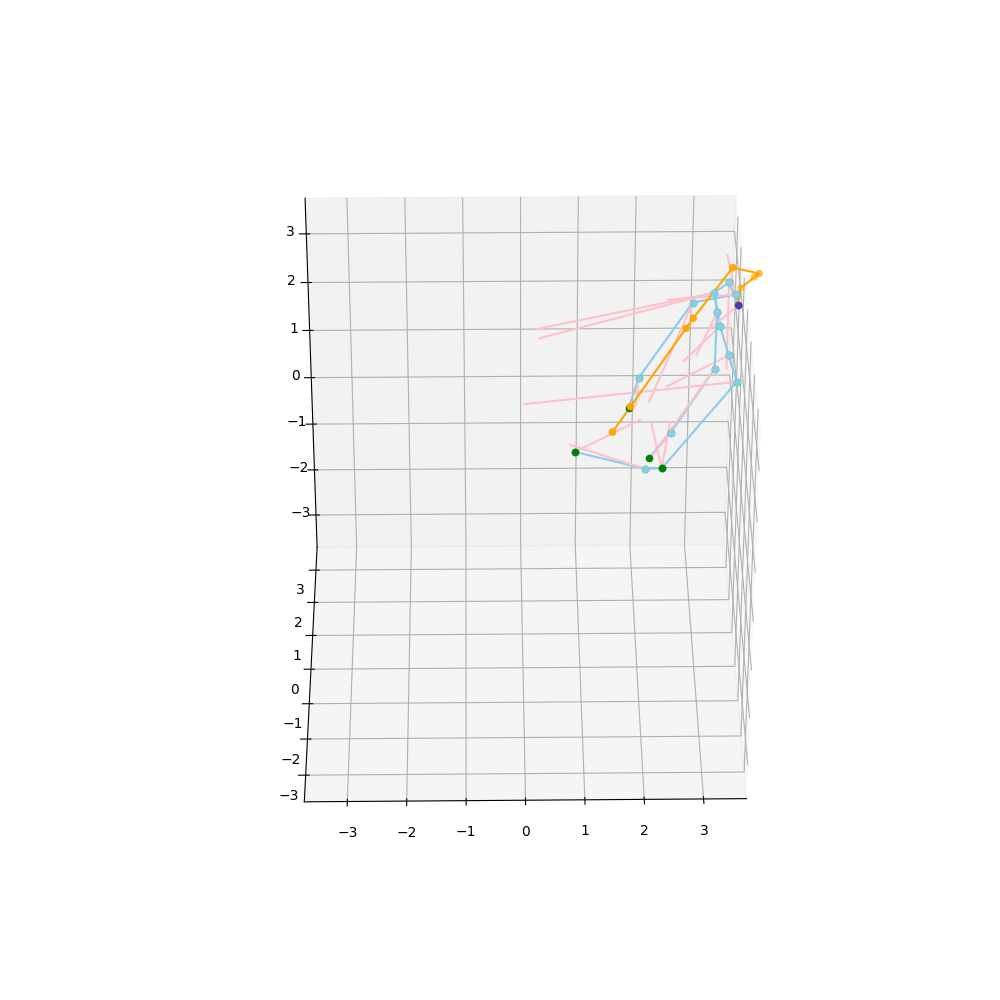

(-5.0, 5.0)

In [18]:
%matplotlib notebook

env_id = 5
traj_id = 950

data, planner = experiment_vis(env_id, 
                    traj_id, 
                    verbose=False, 
                    system='quadrotor_obs', 
                    params=params, 
                    number_of_iterations=params['number_of_iterations'])


ref_path = data['path']

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# fig, ax = visualize_quadrotor_path(ref_path, 
#                                    data['start_goal'][0],
#                                    data['start_goal'][-1], 
#                                    obs_list=get_obs_3d('quadrotor_obs',"obs")[env_id])

# state = np.repeat(np.array([ref_path[0].copy()]), params['n_problem'],  axis=0)
actual_state = ref_path[0].copy()

actual_path = []
samples = []

full_time = 0


def visualize_return_state(ax, states, alpha=1):
    ax.scatter(states[0], states[1], states[2], c='skyblue')
    ax.scatter(states[13], states[14], states[15], c='green')
    ax.plot([states[0], states[13]], [states[1], states[14]], [states[2], states[15]], c='skyblue')
    ax.plot([states[0], states[26]], [states[1], states[27]], [states[2], states[28]], c='pink')


import time
for iteration in tqdm(range(params['number_of_iterations'])):
    states = planner.deep_smp_step(params['refine'], 
                                   refine_threshold=params['refine_threshold'],
                                   using_one_step_cost=params['using_one_step_cost'],
                                   cost_reselection=params['cost_reselection'],
                                   NP=params['n_problem'])
    solution = planner.get_solution()
    if solution is not None:
        break
#     print(states[:])
    if np.linalg.norm(states[13:26]) > 1e-10:
        visualize_return_state(ax, states)    

actual_path = np.array(actual_path)


ax.plot(ref_path[:, 0], ref_path[:, 1], ref_path[:, 2], c='orange')
ax.scatter(ref_path[:, 0], ref_path[:, 1], ref_path[:, 2], c='orange')
ax.scatter(ref_path[0, 0], ref_path[0, 1], ref_path[0, 2], c='blue')

# ax.plot(actual_path[:, 0], actual_path[:, 1], actual_path[:, 2])
# ax.scatter(actual_path[:, 0], actual_path[:, 1], actual_path[:, 2])
ax.set_xlim3d(-5, 5)
ax.set_ylim3d(-5, 5)
ax.set_zlim3d(-5, 5)

<IPython.core.display.Javascript object>


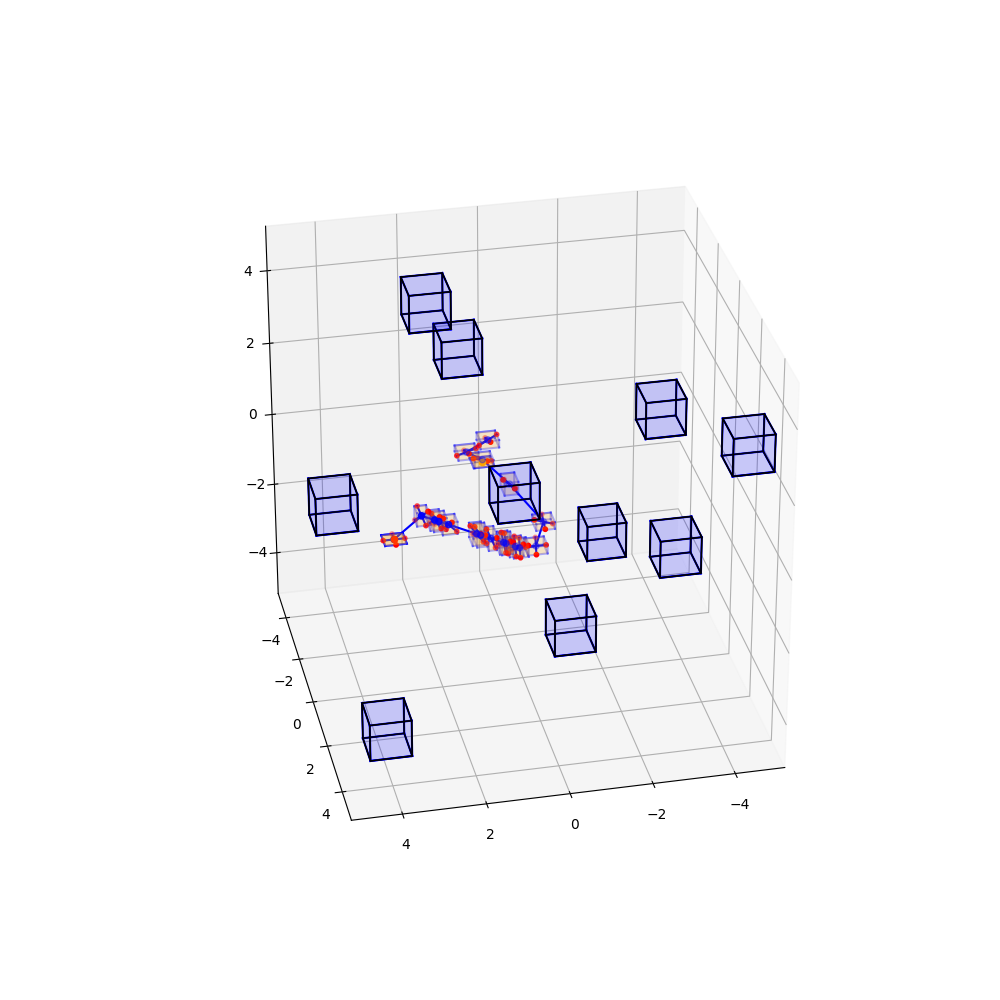

In [17]:
%matplotlib notebook

path = solution[0]
fig, bx = visualize_quadrotor_path(path, 
                                   data['start_goal'][0],
                                   data['start_goal'][-1], 
                                   obs_list=get_obs_3d('quadrotor_obs',"obs")[env_id])